In [1]:
import numpy as np
import pandas as pd

from aeon.visualisation import plot_critical_difference
from aeon.visualisation import plot_pairwise_scatter

from labicompare.visualization import generate_mcm, critical_difference_diagram

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler

import json

In [2]:
mlp = pd.read_csv('results/[end] MLP.csv')
fcn = pd.read_csv('results/[end] FCN.csv')
convtran = pd.read_csv('results/[end] ConvTran.csv')
tsermamba = pd.read_csv('results/[end] TSERMamba.csv')
mini_rocket = pd.read_csv('results/[end] MiniROCKET.csv')
xgboost = pd.read_csv('results/[end] XGBoost.csv')
random_forest = pd.read_csv('results/[end] RandomForest.csv')

In [3]:
mlp = mlp.sort_values(by='dataset').set_index('dataset')
fcn = fcn.sort_values(by='dataset').set_index('dataset')
convtran = convtran.sort_values(by='dataset').set_index('dataset')
tsermamba = tsermamba.sort_values(by='dataset').set_index('dataset')
mini_rocket = mini_rocket.sort_values(by='dataset').set_index('dataset')
xgboost = xgboost.sort_values(by='dataset').set_index('dataset')
random_forest = random_forest.sort_values(by='dataset').set_index('dataset')

metrics = pd.DataFrame({
    'mlp': mlp['rmse'],
    'fcn': fcn['rmse'],
    'convtran': convtran['rmse'],
    'tsermamba': tsermamba['rmse'],
    'mini_rocket': mini_rocket['rmse'],
    'xgboost': xgboost['rmse'],
    'random_forest': random_forest['rmse']
})

# metrics = metrics.dropna(subset=['rocket'])

# metrics = metrics.drop(['BIDMC32HR', 'BIDMC32RR', 'BIDMC32SpO2'], axis=0)

metrics

,mlp,fcn,convtran,tsermamba,mini_rocket,xgboost,random_forest
dataset,,,,,,,
AppliancesEnergy,3.416436,2.829873,2.778814,3.541914,2.517430,2.323818,2.285652
AustraliaRainfall,8.483223,8.561270,10.112963,8.529031,9.976285,18.325059,9.609848
BIDMC32HR,13.443014,7.273788,4.585035,9.967628,7.868326,9.870483,10.344398
BIDMC32RR,3.663970,4.072824,3.713405,4.956176,4.134451,3.958758,3.835444
BIDMC32SpO2,4.689669,5.555124,5.184596,5.029221,5.574146,5.114320,4.893057
BeijingPM10Quality,119.633397,117.574150,127.223239,116.608201,125.370617,121.536481,118.670067
BeijingPM25Quality,87.844715,84.335811,94.716624,89.679407,90.468657,92.756422,91.010118
BenzeneConcentration,4.234673,3.338947,3.564750,4.468293,11.301798,3.667087,3.606147
Covid3Month,0.047392,0.060006,0.050733,0.043434,0.041712,0.050933,0.045930


In [4]:
metrics.rank(axis=1)

,mlp,fcn,convtran,tsermamba,mini_rocket,xgboost,random_forest
dataset,,,,,,,
AppliancesEnergy,6.0,5.0,4.0,7.0,3.0,2.0,1.0
AustraliaRainfall,1.0,3.0,6.0,2.0,5.0,7.0,4.0
BIDMC32HR,7.0,2.0,1.0,5.0,3.0,4.0,6.0
BIDMC32RR,1.0,5.0,2.0,7.0,6.0,4.0,3.0
BIDMC32SpO2,1.0,6.0,5.0,3.0,7.0,4.0,2.0
BeijingPM10Quality,4.0,2.0,7.0,1.0,6.0,5.0,3.0
BeijingPM25Quality,2.0,1.0,7.0,3.0,4.0,6.0,5.0
BenzeneConcentration,5.0,1.0,2.0,6.0,7.0,4.0,3.0
Covid3Month,4.0,7.0,5.0,2.0,1.0,6.0,3.0


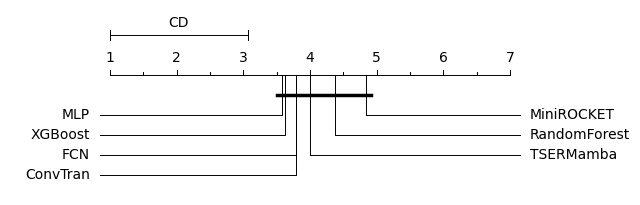

In [5]:
name = {'mlp':'MLP', 'fcn':'FCN', 'convtran':'ConvTran', 'tsermamba':'TSERMamba',
        'mini_rocket':'MiniROCKET', 'xgboost':'XGBoost', 'random_forest':'RandomForest'}
metrics.columns = [name[col] for col in metrics.columns]

fig_nem = critical_difference_diagram(
    metrics,
    test='nemenyi',
    alpha=0.05
)

# critical_difference_diagram(
#     metrics,
#     test='wilcoxon',
#     alpha=0.05
# )   

In [6]:
ranks = metrics.rank(axis=1)
all_ranks = sorted(list(set(ranks.values.flatten().astype(int).tolist())))

# Count occurrences of each rank per model
ranks_counts = {
    col: ranks[col].value_counts().reindex(all_ranks, fill_value=0).sort_index()
    for col in ranks.columns
}

# Create DataFrame of rank counts
ranks_df = pd.DataFrame(ranks_counts)
ranks_df = ranks_df[metrics.columns]

# Transpose: models as rows, ranks as columns
ranks_df_t = ranks_df.T
ranks_df_t.columns = [f"{c}º" for c in ranks_df_t.columns]

# Sort by number of 1st, 2nd, ... positions (descending)
ranks_df_t = ranks_df_t.sort_values(
    by=ranks_df_t.columns.tolist(),
    ascending=[False] * len(ranks_df_t.columns)
)

# Compute mean rank (weighted average of positions)
positions = np.array(all_ranks)
ranks_df_t["Mean"] = (
    (ranks_df_t.values[:, :len(all_ranks)] * positions).sum(axis=1)
    / ranks_df_t.iloc[:, :len(all_ranks)].sum(axis=1)
)

# Reorder columns: ranks first, then mean
rank_cols = [f"{c}º" for c in all_ranks]
ranks_df_t = ranks_df_t[rank_cols + ["Mean"]]

ranks_df_t

,1º,2º,3º,4º,5º,6º,7º,Mean
MiniROCKET,6,3,3,2,1,2,2,3.157895
MLP,4,2,0,2,3,3,5,4.421053
TSERMamba,3,4,3,1,1,2,5,4.000000
FCN,2,4,3,0,2,5,3,4.210526
ConvTran,2,3,3,1,4,3,3,4.210526
RandomForest,2,1,6,5,3,2,0,3.631579
XGBoost,0,2,1,8,5,2,1,4.368421


Processing RandomForest, XGBoost:   0%|          | 0/7 [00:00<?, ?it/s]   


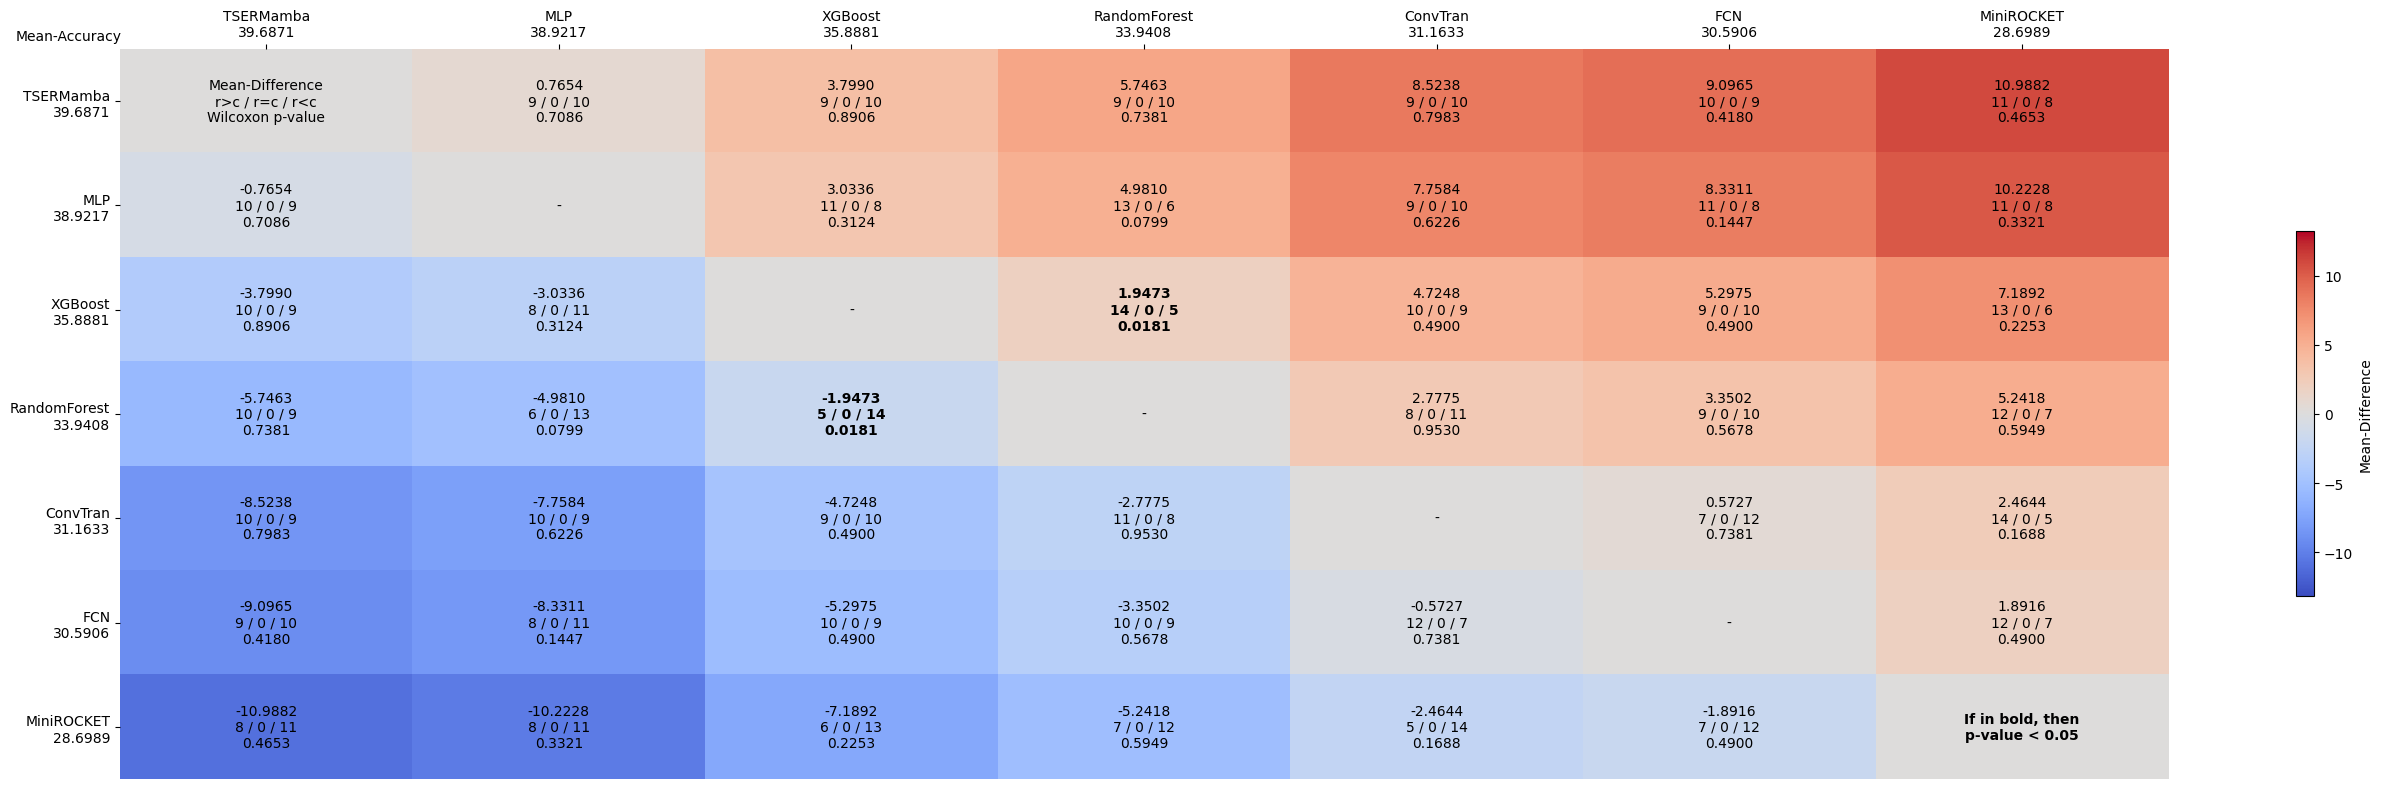

In [7]:
fig = generate_mcm(metrics)

O que discutir
- CDD
- MCM
- Distribuições dos rankings
    - (ins)estabilidade dos rankings
- Tempo de exec para justificar os datasets
- Qtd de parâmetros
- Análise qualitativa dos datasets em que os modelos adaptados foram bem/mal
- TSERMamba vs ConvTran
- Distribution of relative RMSE  (BoxPlot from TSER2 paper)